In [1]:
%cd ..

from src.nn.ansatz.default import default_circuit, custom_circuit
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.waterfall_embedding import *
from src.nn.models.hybrid.HQNN_Parallel import HQNN_Parallel

import torch
import time
import numpy as np
import pennylane as qml

from src.nn.encodings import *
from src.nn.ansatz import *


from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit

from src.nn.measurements.default import default_measurement

from src.utils.dataset import load_dataset
#from src.utils.load_params import load_params
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer


import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification


In [2]:
%pwd

'/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification'

In [3]:
print(amplitude_embedding)

<function amplitude_embedding at 0x143cadbc0>


In [4]:
waterfall_embedding = waterfall_embedding.waterfall_embedding #without this it breaks bc it recognizes waterfall embedding as  <module 'src.nn.encodings.waterfall_embedding' from '/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/src/nn/encodings/waterfall_embedding.py'>

In [5]:
print(waterfall_embedding)

<function waterfall_embedding at 0x143cae3e0>


In [6]:
limit = 500
dataset_ = "EuroSAT"
image_size = 32
test_size = 0.2
output = 'np' # 'np' or 'dl'
batch_size = 16

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']

config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size, batch_size)

device = "mps" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

Using device: mps


# HQNN-Parallel - 32x32x3

In [7]:
use_quantum, log_wandb, plot = False, False, True
n_classes = len(allowed_classes)
early_stopping, patience = False, 4

name_run = "HQNN_Parallel"
num_qubits_per_circuit = 8
learning_rate = 0.01
epochs = 10

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [8]:
amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {

    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

num_layers = 2
weights_strongly_entangled = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi
weights_random = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi

default_circuit_params = {
    "func": default_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_random,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit)},
    }
}

strongly_entangled_circuit_params = {
    "func": custom_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_strongly_entangled,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit, 3)},
    }
}

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliX,
        "measured_qubits": range(num_qubits_per_circuit),
    }
}

In [9]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True)

In [10]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-31 10:23:45.768 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 1.9051, Train Acc = 24.68%, Val Loss = 1.7261, Val Acc = 33.00%
2025-03-31 10:37:06.728 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.6670, Train Acc = 33.75%, Val Loss = 1.6715, Val Acc = 33.30%
2025-03-31 10:50:06.987 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 1.6235, Train Acc = 36.90%, Val Loss = 1.5998, Val Acc = 38.20%
2025-03-31 11:02:55.733 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 1.5247, Train Acc = 41.77%, Val Loss = 1.5501, Val Acc = 41.50%
2025-03-31 11:15:49.212 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 1.4460, Train Acc = 44.73%, Val Loss = 1.4803, Val Acc = 46.70%
2025-03-31 11:28:44.595 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 1.4251, Train Acc = 45.23%, Val Loss = 1.4747, Val Acc = 45.20%
2025-03-31 11:41:18.510 | DEBUG    | src.utils.training:fi

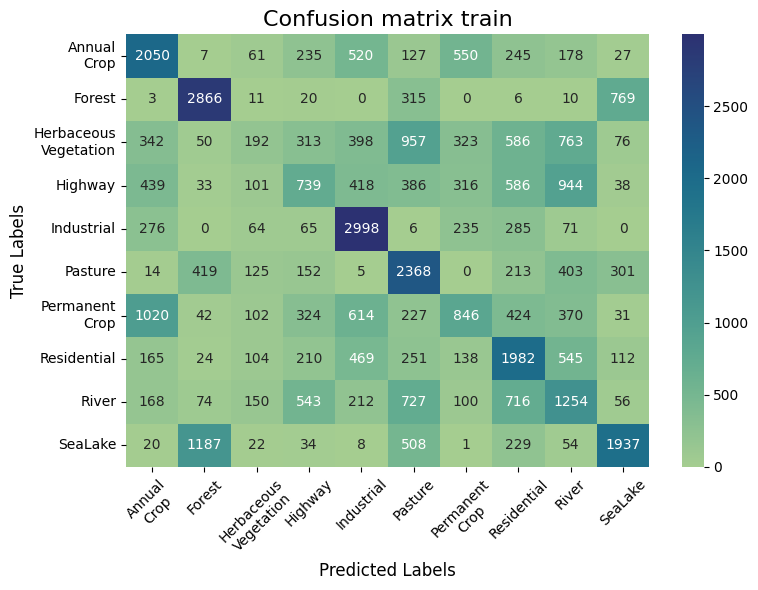

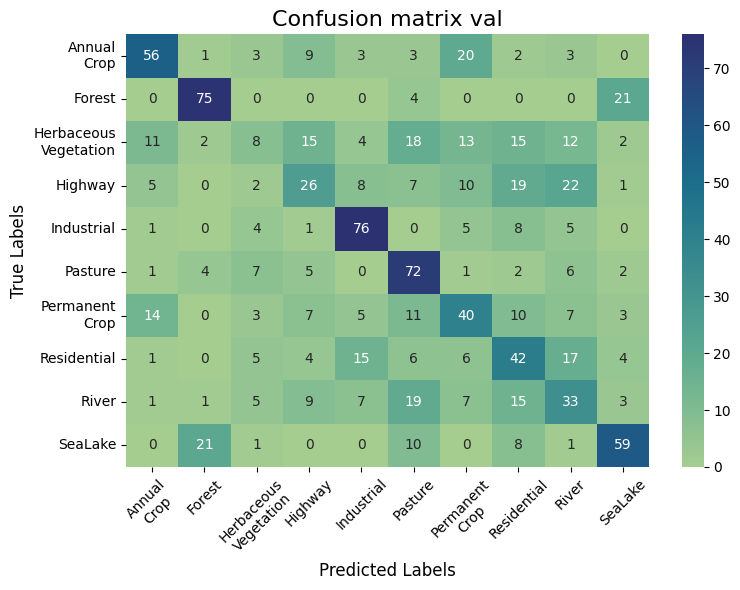

In [11]:
trainer.fit()

In [12]:
model = HQNN_Parallel(waterfall_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True)

In [13]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

In [ ]:
trainer.fit()

# HQNN_Parallel - 16x16x3

In [15]:
%pwd

'/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification'

In [16]:
%cd notebooks
limit = 500
dataset_ = "DeepSat4"
image_size = 16
test_size = 0.2
output = 'np' # 'np' or 'dl'
batch_size = 16

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']

config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

/Users/uribagi/Documents/GitHub/QML-Satellite-Image-Classification/notebooks


In [17]:
use_quantum, log_wandb, plot = False, False, True
n_classes = len(allowed_classes)
early_stopping, patience = False, 4

name_run = "HQNN_Parallel"
num_qubits_per_circuit = 8
learning_rate = 0.01
epochs = 10

print("Testing with the", dataset_, "dataset")

Testing with the DeepSat4 dataset


In [18]:
amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {

    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

num_layers = 2
weights_strongly_entangled = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi
weights_random = (2 * torch.rand(num_layers, num_qubits_per_circuit, 3) - 1) * np.pi

default_circuit_params = {
    "func": default_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_random,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit)},
    }
}

strongly_entangled_circuit_params = {
    "func": custom_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": weights_strongly_entangled,
        "weight_shapes": {"weights": (num_layers, num_qubits_per_circuit, 3)},
    }
}

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliX,
        "measured_qubits": range(num_qubits_per_circuit),
    }
}

In [19]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True, input_size=16, dataset="DeepSat4")

In [20]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-30 15:46:49.403 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 1.4440, Train Acc = 27.06%, Val Loss = 1.2167, Val Acc = 51.00%
2025-03-30 15:49:18.059 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.2251, Train Acc = 42.75%, Val Loss = 0.9925, Val Acc = 55.25%
2025-03-30 15:51:43.676 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 1.0858, Train Acc = 50.31%, Val Loss = 0.8901, Val Acc = 62.50%
2025-03-30 15:54:11.736 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 0.8830, Train Acc = 60.19%, Val Loss = 0.7237, Val Acc = 71.25%
2025-03-30 15:56:40.173 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 0.8378, Train Acc = 64.06%, Val Loss = 0.7548, Val Acc = 69.25%
2025-03-30 15:59:08.655 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 0.7314, Train Acc = 69.38%, Val Loss = 0.6598, Val Acc = 74.00%
2025-03-30 16:01:37.301 | DEBUG    | src.utils.training:fi

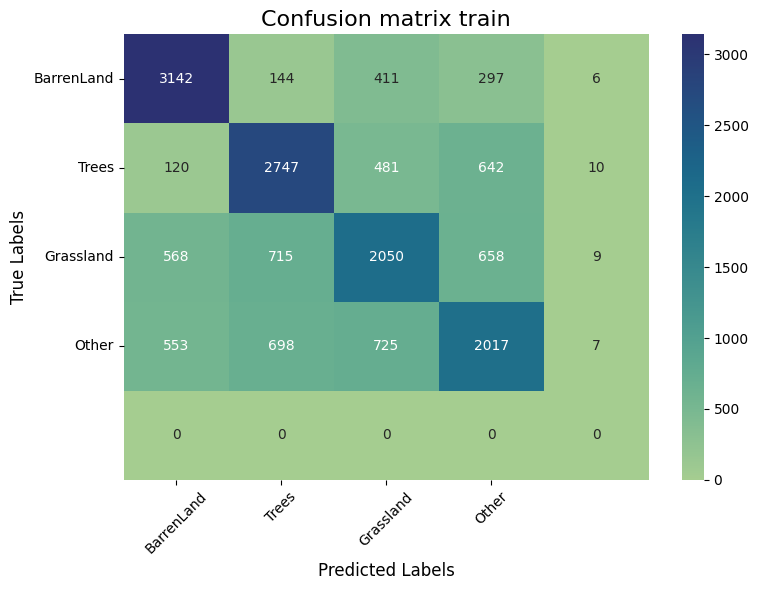

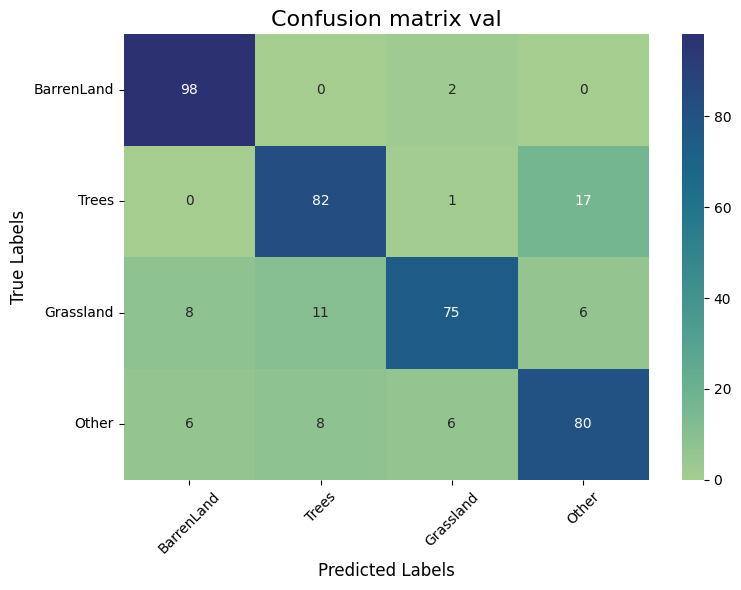

In [21]:
trainer.fit()

In [22]:
model = HQNN_Parallel(iqp_encoding_params, strongly_entangled_circuit_params, measurement_params, use_quantum=True, input_size=16 , dataset="DeepSat4")

In [23]:
trainer = Trainer(model = model,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree=True
                 )

2025-03-30 16:11:23.808 | DEBUG    | src.utils.training:fit:226 - Epoch [1/10]: Train Loss = 1.4396, Train Acc = 25.06%, Val Loss = 1.2496, Val Acc = 56.50%
2025-03-30 16:13:51.045 | DEBUG    | src.utils.training:fit:226 - Epoch [2/10]: Train Loss = 1.1984, Train Acc = 43.44%, Val Loss = 0.9271, Val Acc = 61.00%
2025-03-30 16:16:15.897 | DEBUG    | src.utils.training:fit:226 - Epoch [3/10]: Train Loss = 0.9768, Train Acc = 56.81%, Val Loss = 0.8275, Val Acc = 65.50%
2025-03-30 16:18:37.922 | DEBUG    | src.utils.training:fit:226 - Epoch [4/10]: Train Loss = 0.8612, Train Acc = 63.38%, Val Loss = 0.7138, Val Acc = 70.50%
2025-03-30 16:20:58.539 | DEBUG    | src.utils.training:fit:226 - Epoch [5/10]: Train Loss = 0.7814, Train Acc = 67.31%, Val Loss = 0.7343, Val Acc = 68.75%
2025-03-30 16:23:24.219 | DEBUG    | src.utils.training:fit:226 - Epoch [6/10]: Train Loss = 0.7007, Train Acc = 69.50%, Val Loss = 0.6608, Val Acc = 73.50%
2025-03-30 16:25:46.061 | DEBUG    | src.utils.training:fi

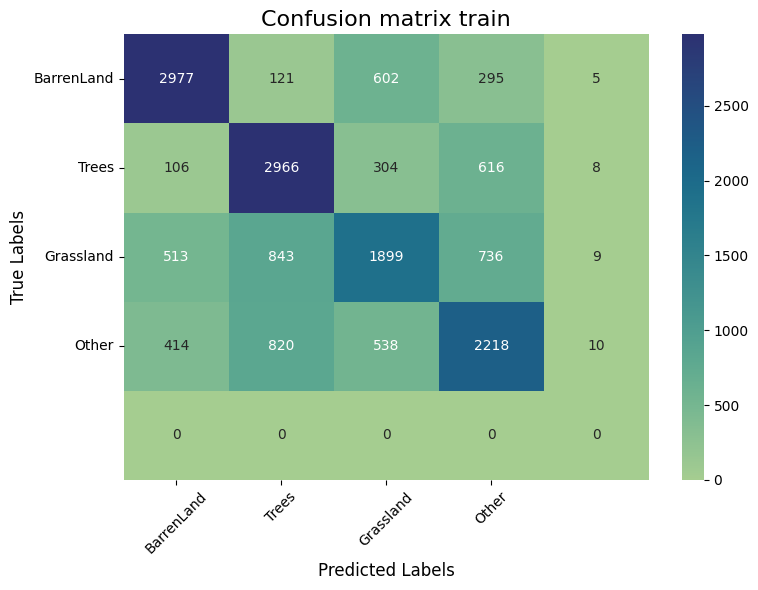

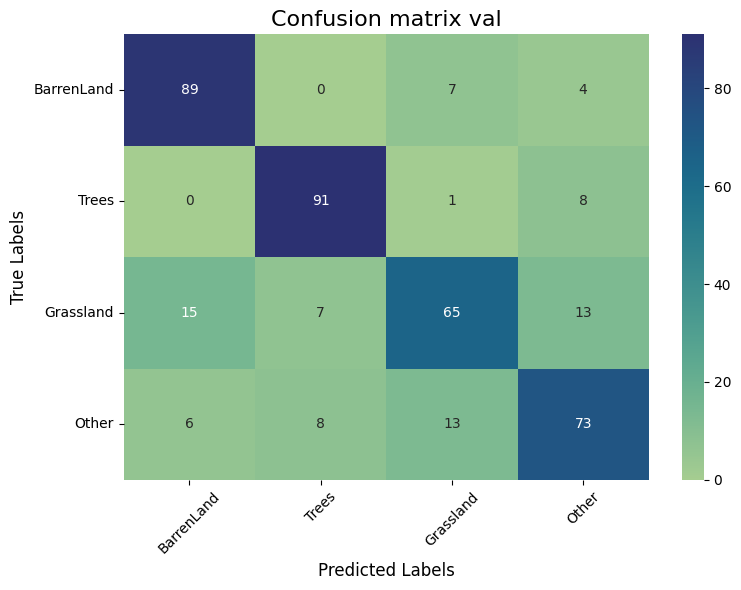

In [24]:
trainer.fit()